## ML Group Assignment - Predicting YouTube video popularity

### **Group 20**
#### Authors
##### Orfeas Bourchas, PhD Candidate, School of Naval Architecture & Marine Engineering
##### Nikos Silionis, PhD Candidate, School of Naval Architecture & Marine Engineering
##### Dimitris Tsoumpelis, PhD Candidate, School of Naval Architecture & Marine Engineering

This notebook deals with predicting Youtube video popularity using textual data to extract the necessary features. As popularity is a concept that is not clearly defined, we will follow the example of Li et al. (2019) where the problem is treated as a supervised learning problem. In this context, we will define a labeling index, based on the video characteristics we have determined to influence popularity. We then perform a basic statistical analysis of this quantity in order to separate the data to classes. In terms of the feature extraction process, the video titles from the Canadian and U.S. datasets are employed as text data. We perform basic text cleaning and lemmatization to create a vocabulary and then use that to train a word embeddings model, specifically the Word2Vec model. Then, the trained word embeddings model is used on the US data to test different neural network architectures to perform the multi-class classification process.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Importing data

Out of the various available datasets from different countries, for our demonstration we will select the data corresponding to users from the United States and Canada.

In [ ]:
US_videos = pd.read_csv('../input/youtube-new/USvideos.csv')
US_videos.head()

In [ ]:
CA_videos = pd.read_csv('../input/youtube-new/CAvideos.csv')
CA_videos.head()

Now, we check the size and shape of the imported dataframes.

In [ ]:
US_videos.shape

In [ ]:
CA_videos.shape

In [ ]:
US_videos.columns

By going through the dataset particulars, we can readily conclude that some of the columns will not be relevant to our analysis going forward. For example, the thumbnail link and video id can be judged as not useful features even by simply inspecting them. So, let's drop them from the dataframe completely.

In [ ]:
US_videos.drop(['video_id', 'thumbnail_link'], axis=1, inplace=True)

Now we remove the videos with disabled comments from the datasets.

In [ ]:
dis_coms = US_videos[(US_videos['comments_disabled'] == True)].index

In [ ]:
US_videos = US_videos.drop(index=dis_coms)

In [ ]:
US_videos.shape

In [ ]:
US_videos[(US_videos['comments_disabled'] == True)]['comments_disabled'].count()

Now, we remove the videos with disabled ratings.

In [ ]:
dis_rtg = US_videos[(US_videos['ratings_disabled'] == True)].index
US_videos = US_videos.drop(index=dis_rtg)

In [ ]:
US_videos.shape

In [ ]:
US_videos[(US_videos['ratings_disabled'] == True)]['ratings_disabled'].count()

At this stage, we have successfully removed those videos from our dataframe. The next stage in the cleanup process will be to remove the videos for which the likes/dislikes ratio is below 1. These are the videos we have considered as "unrepresentative", as they indicate videos with polarizing subjects where judging popularity cannot be clearly estimated.

In [ ]:
US_videos['likes_to_dislikes'] = (US_videos['likes']+1)/(US_videos['dislikes']+1)
US_videos['likes_to_dislikes'].describe()

In [ ]:
US_videos[US_videos['likes_to_dislikes'] < 1 ]['likes_to_dislikes'].count() / US_videos['likes_to_dislikes'].count() * 100

There has been a slight reduction in this fraction, as expected. As before, we will store the indices of the videos that satisfy the above criterion and then remove them from the datset.

In [ ]:
polar_vids = US_videos[(US_videos['likes_to_dislikes'] < 1 )].index
print(polar_vids.shape)
polar_vids

In [ ]:
US_videos = US_videos.drop(index = polar_vids)
US_videos.shape

In [ ]:
US_videos['comments_to_views'] = US_videos['comment_count']/US_videos['views']

In [ ]:
# import matplotlib.pyplot as plt

fig, ax = plt.subplots()
_ = sns.distplot(US_videos["comments_to_views"], kde=False, rug=False, 
                 hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 0.08, 49), ax=ax)
_ = ax.set(xlabel="Comments/Views", ylabel="No. of videos")

Let's visualize the likes/dislikes ratio using a histogram, to verify that the changes we applied have been successfully implemented.

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(US_videos["likes_to_dislikes"], kde=False, rug=False, 
                 hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 400, 49), ax=ax)
_ = ax.set(xlabel="Likes/Dislikes", ylabel="No. of videos")

The labeling index is now defined as follows:
$$ l_{ind} = \frac{comments}{views}\frac{likes}{dislikes}$$

This type of score maintains the popularity trends we have observed based on the histograms of the views, comments, likes and dislikes, which we consider to be the quantities that largely characterize the popularity of a given YouTube video.

In [ ]:
labeling_index = US_videos['likes_to_dislikes']*US_videos['comments_to_views']

In [ ]:
labeling_index.describe()

In [ ]:
fig, ax = plt.subplots()
_ = sns.distplot(labeling_index, kde=False, rug=False, 
                 hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 2.5, 49), ax=ax)
_ = ax.set(xlabel="(Likes/Dislikes)x(Comments/Views)", ylabel="No. of videos")

Now, we will check the percentage of videos that are below certain characteristic values of the labeling index, to decide upon the boundaries used to define the different classes.

Percentage of labeling index under 0.5

In [ ]:
labeling_index[labeling_index<0.5].count()/labeling_index.count()*100

Percentage under 0.25.

In [ ]:
labeling_index[labeling_index<0.25].count()/labeling_index.count()*100

Percentage under 0.05.

In [ ]:
labeling_index[labeling_index<0.05].count()/labeling_index.count()*100

Based on the above, we will now describe and consequently apply the proposed labeling strategy. The flowchart that follows describes the labeling process.

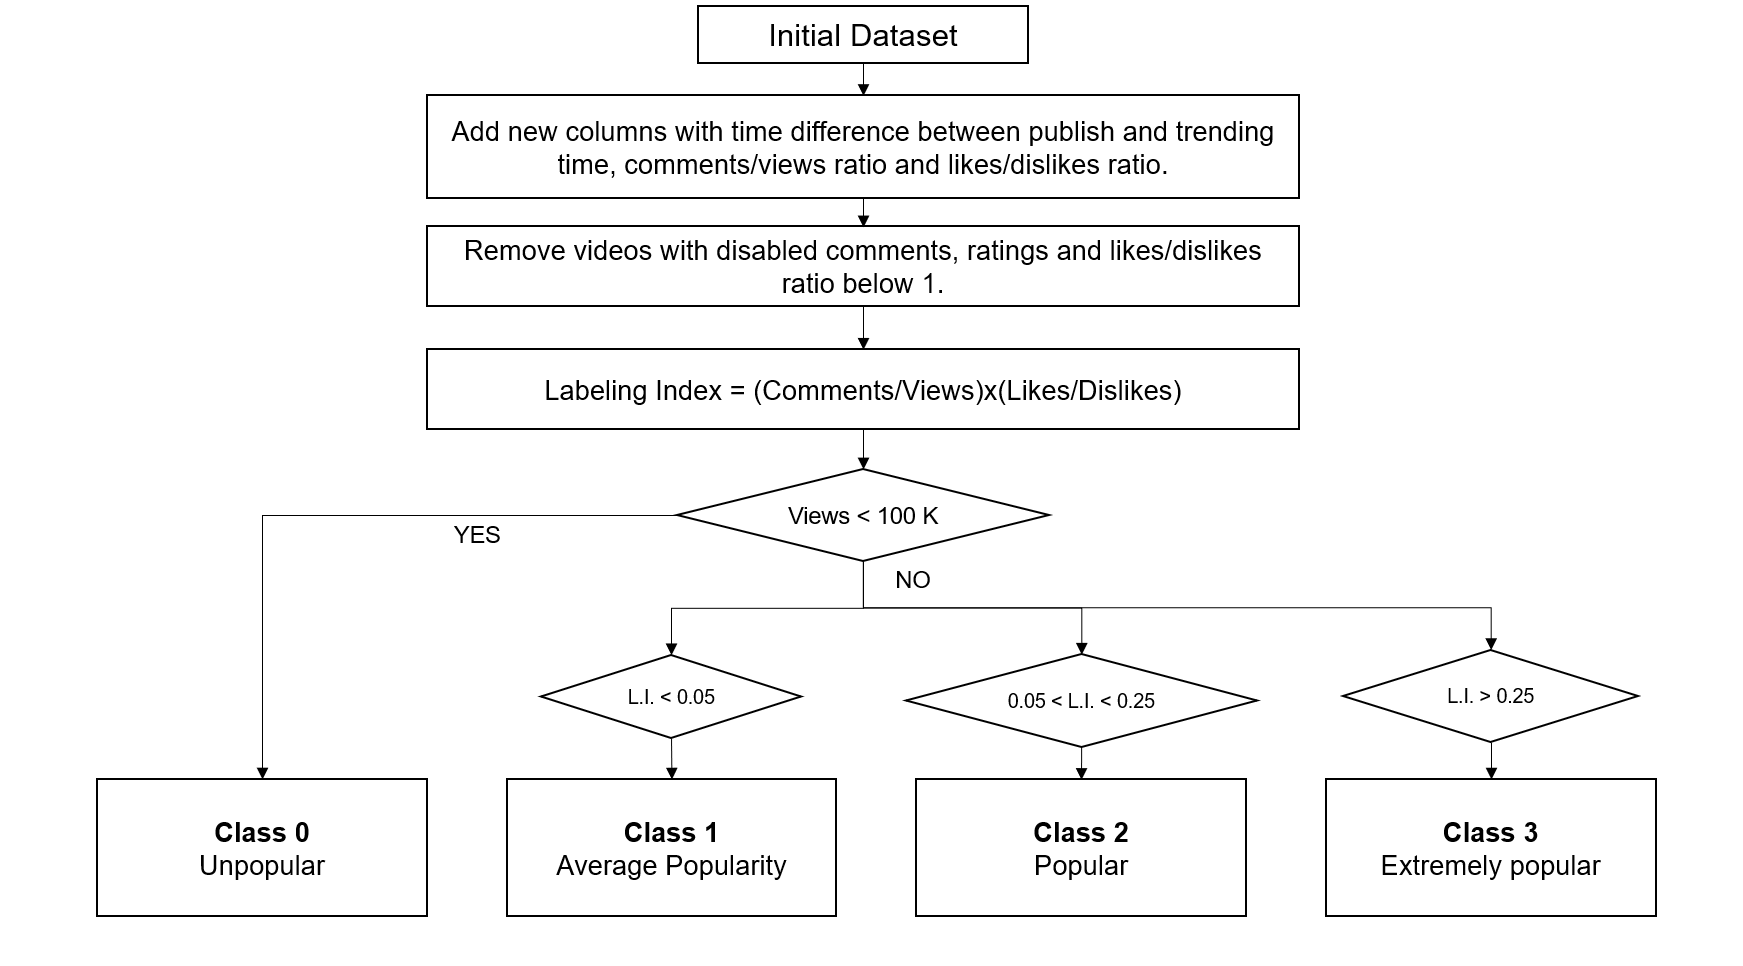

Now, we store the indices of videos from the DataFrame that correspond to the different classes and assign labels accordingly.

In [ ]:
zero_ind = US_videos[(US_videos['views'] < 1e5)].index
zero_ind.shape

In [ ]:
zero_ind

In [ ]:
zero_class_pct = (zero_ind.shape[0]/US_videos.shape[0])*100

In [ ]:
zero_class_pct

In [ ]:
one_ind = US_videos[(US_videos['views'] > 1e5) & (labeling_index < 0.05)].index
one_ind.shape

In [ ]:
class_one_pct = (one_ind.shape[0]/US_videos.shape[0])*100
class_one_pct

In [ ]:
two_ind = US_videos[(US_videos['views'] > 1e5) & (labeling_index > 0.05) & (labeling_index < 0.25)].index
two_ind.shape

In [ ]:
class_two_pct = (two_ind.shape[0]/US_videos.shape[0])*100
class_two_pct

In [ ]:
three_ind = US_videos[(US_videos['views'] > 1e5) & (labeling_index > 0.25)].index
three_ind.shape

In [ ]:
class_three_pct = (three_ind.shape[0]/US_videos.shape[0])*100
class_three_pct

In [ ]:
US_videos.shape[0]

In [ ]:
zero_class_pct + class_one_pct + class_two_pct + class_three_pct

In [ ]:
US_videos['label'] = 0

In [ ]:
US_videos['label'].isna().sum()

In [ ]:
US_videos['label'][zero_ind] = 0
US_videos['label'][one_ind] = 1
US_videos['label'][two_ind] = 2
US_videos['label'][three_ind] = 3


In [ ]:
US_videos['label'].isna().sum()

In [ ]:
US_videos.head()

Now, we shall extract the textual data from our dataframe. We will use video titles, as we consider them to be the most informative piece of textual data in terms of determining popularity. We consider this due to the fact that most people decide on watching a video primarily based on the video title.

#### Text Processing

In this section, text mining techniques are used to process the video titles. Word embeddings in particular are to be employed  to extract features from text data. First, we perform  some basic cleanup on the text data, using an English dictionary.

In [ ]:
import spacy
from spacy.lang.en import English
import regex as re  # For preprocessing
nlp = spacy.load('en_core_web_sm' , disable=['parser'])

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Initially, we create a new DataFrame containing the titles for each video from the two datasets.

In [ ]:
text_data = pd.DataFrame({'titles': US_videos['title']})

In [ ]:
corpus = pd.concat([US_videos['title'], CA_videos['title']], ignore_index=True)

Here, we keep the US video titles separately along with their corresponding labels. This will help us implement the classification framework later on.

In [ ]:
clf_data = pd.DataFrame({'titles': US_videos['title']}) 
clf_data['labels'] = US_videos['label']

In [ ]:
clf_data.head()

Now, we set up a pipeline to clean up our text. Basically, we will first use `brief_cleaning` to replace non-normal characters with spaces and then feed them to the cleaning function defined earlier that performs lemmatization and stopword removal. This is implemented within a pipeline to improve code performance.

In [ ]:
brief_cleaning = (re.sub(r'[^\w]|_', ' ', str(row)).lower() for row in corpus) 

In [ ]:
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process = 1)] # lemmatization and stopword removal

Let's check the various words contained in a specific title after the clean-up process.

In [ ]:
str(txt[30000].split())

We will load the cleaned up titles in a dataframe and remove the empty entries created by the cleaning process.

In [ ]:
df_clean = pd.DataFrame({'clean': txt})
#df_clean['labels'] = text_data['labels']
df_clean = df_clean.dropna()
df_clean.shape

We repeat the clean-up process for the US data only, to enable us to use it later for the classification task.

In [ ]:
brief_cleaning_clf = (re.sub(r'[^\w]|_', ' ', str(row)).lower() for row in clf_data['titles'])
txt_clf = [cleaning(doc) for doc in nlp.pipe(brief_cleaning_clf, batch_size=5000, n_process = 1)] # lemmatization and stopword removal
df_clf_clean = pd.DataFrame({'clean': txt_clf})
df_clf_clean['labels'] = clf_data['labels']
df_clf_clean = df_clf_clean.dropna()
df_clf_clean.shape

Now, we isolate the words in each title (as sent) and then use `Phraser` and `Phrases` to determine word frequences.

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
sent = [row.split() for row in df_clean['clean']] # 'word1 word2' --> ['word1' , 'word2']

In [ ]:
sent[0]

In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
ngram = Phraser(phrases)

In [ ]:
sentences = ngram[sent]

Now, we load the Word2Vec model from gensim and instantiate the model. Then we use it to build our vocabulary and train a word embeddings model using that.

In [ ]:
from gensim.models import Word2Vec

In [ ]:
cores = 4
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

Now, we evaluate our word embeddings model by checking similarity of certain words we know appear in the dataset. We will check using the word "trump", as the former US president was a trending topic of conversation during 2017-2018 when the videos in this dataset were published.

In [ ]:
w2v_model.wv.most_similar(positive=["trump"])

Based on our knowledge of current affairs, we can definitely see that our trained model returns words that are similar to issues faced by Trump at the time, as well as others that reflect popular opinion towards him. Up next, we take transform the words in each title to a 300-dimensional vector and then take their average to represent each title.

In [ ]:
i=0
vectors = []
for words in sentences[:]: # !!! for some reason not all the words in 'sentences' are recognized (???)
    if i==0 :
        vectors.append( np.mean(w2v_model.wv.__getitem__(words) , axis=0) ) # we obtain the vector for each word and take the average to represent the sentence
        i+=1
    else:
        vectors.append( np.mean(w2v_model.wv.__getitem__(words) , axis=0) )

In [ ]:
len(vectors)

Now, we extract the vectors corresponding to US data, which we will use in our classification framework.

In [ ]:
df_clf = pd.DataFrame(vectors[0:df_clf_clean.shape[0]])

In [ ]:
df_clf.shape

Now, we assign the labels.

In [ ]:
df_clf['labels'] = 0

In [ ]:
labels = np.array(df_clf_clean['labels'])

We check now for any missing labels.

In [ ]:
np.isnan(labels).sum()

In [ ]:
df_clf['labels'] = labels

In [ ]:
df_clf.tail()

Now, before implementing the classification process we check whether any data are missing.

In [ ]:
df_clf[df_clf['labels'].isnull()].index

Now, we split our data to training and validation sets using a 70/30 split.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_clf, test_size=0.30)

In [ ]:
train.head()

Following, we extract the features and labels from both sets.

In [ ]:
X_train = np.array(train.iloc[:,0:300])

In [ ]:
X_train.shape

In [ ]:
Y_train = np.array(train['labels'])
print(Y_train.shape)
print(Y_train[0])

We transform our training labels to categorical form, using one-hot encoding.

In [ ]:
import tensorflow
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train)

In [ ]:
X_test = np.array(test.iloc[:,0:300])
X_test.shape

In [ ]:
Y_test = np.array(test['labels'])
print(Y_test.shape)
print(Y_test[0])

We transform our test labels to categorical form, using one-hot encoding.

In [ ]:
Y_test = to_categorical(Y_test)

In [ ]:
Y_train.shape

At this point, we will use PCA to examine whether we can reduce the dimensionality of our feature space before training a multi-layer perceptron. We will judge the number of principal components to retain based on the variance of the data they capture.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=50)
#rndom = np.random.rand(100,100)
#red = pca.fit_transform(rndom)
vects = pca.fit_transform(X_train)

evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(10, 6))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, 'bo', linewidth=1)
plt.show()

By retaining 100 principal components, i.e., reducing the feature dimension by a factor of 3, we can retain ~85% of the variance in the data. By retaining 50, we capture ~65% of the variance. So, let's try and build a multi-layer perceptron using these principal components as features. Before we do that, we tranform the test vectors using the same transformation matrix learned by PCA from the training data.

In [ ]:
test_vects = pca.transform(X_test)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model2 = keras.Sequential()
model2.add(layers.Dense(300, activation='relu', input_shape=(vects[1].shape)))
#kernel_regularizer=keras.regularizers.l2(0.001)
#model.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
#model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
#model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))
model2.add(layers.Dense(4, activation='softmax'))
model2.compile(optimizer=tf.optimizers.RMSprop(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

model2.fit(vects, Y_train.astype(int), batch_size=64, epochs=30, validation_data=(test_vects, Y_test.astype(int)))

We see that the MLP faces significant problems with our dataset. We cannot achieve high accuracy, regardless of using dimensionality reduction or not. So, let's try a few more classification strategies to see how they perform. We will use k-NN and Naive Bayes at this point, as they are suitable for multi-class classification problems.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
model_knn = knn.fit(vects, Y_train)
preds_knn = model_knn.predict(test_vects)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

knn_acc = accuracy_score(Y_test, preds_knn)
knn_fsc = f1_score(Y_test, preds_knn, average='macro')
print(f'k-Nearest Neighbor (k-NN) accuracy: {knn_acc} and f1-score: {knn_fsc}.')
print(classification_report(Y_test, preds_knn))

In [ ]:
print(np.argmax(Y_train, axis=1))

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model_gnb = gnb.fit(X_train, np.argmax(Y_train, axis=1))
preds_gnb = model_gnb.predict(X_test)
gnb_acc = accuracy_score(np.argmax(Y_test, axis=1), preds_gnb)
gnb_fsc = f1_score(np.argmax(Y_test, axis=1), preds_gnb, average='macro')
print(f'Gaussian Naive Bayes (GNB) accuracy: {gnb_acc} and f1-score: {gnb_fsc}.')
print(classification_report(np.argmax(Y_test, axis=1), preds_gnb))
